In [10]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]

clearall()

In [11]:
from matplotlib import pyplot as plt
from pandas import json_normalize
import json
import pandas as pd
from tqdm import tqdm
import requests
import time
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import psycopg2

sns.set(rc={'figure.figsize':(11, 4)})

POSTGRES_DATABASE = "analytics"
POSTGRES_USER = "securd_owner"
POSTGRES_HOST = "ep-hidden-field-a2hazh6h.eu-central-1.aws.neon.tech"
POSTGRES_PASSWORD = "US7QapoGT5dh"
POSTGRES_PORT = "5432"

conn = psycopg2.connect(database = POSTGRES_DATABASE, 
                        user = POSTGRES_USER, 
                        host = POSTGRES_HOST,
                        password = POSTGRES_PASSWORD,
                        port = POSTGRES_PORT,
                        sslmode = "require",
                        options = "endpoint=ep-hidden-field-a2hazh6h")


conn

cur = conn.cursor()

cur.execute("""SELECT table_name FROM information_schema.tables
               WHERE table_schema = 'public'""")

for table in cur.fetchall():
    print(table)

cur.execute("""SELECT * FROM analytics """)

for table in cur.fetchall():
    print(table)

conn.commit()
conn.close()

id_blockchain = 2
blockchain_name = "Cronos"
blockchain_type = "EVM"
chain_id = 25

cur.execute("""
    INSERT INTO public.blockchain (id_blockchain,
                                   blockchain_name,
                                   blockchain_type,
                                   chain_id) VALUES

    (%(id_blockchain)s,
     %(blockchain_name)s,
     %(blockchain_type)s,
     %(chain_id)s)""",

    {'id_blockchain': id_blockchain,
     'blockchain_name': blockchain_name,
     'blockchain_type': blockchain_type,
     'chain_id': chain_id})

id_dex = 1
dex_name = "VVS"
dex_type = "CPAMM"

cur.execute("""
    INSERT INTO public.dex (id_dex,
                            dex_name,
                            dex_type) VALUES

    (%(id_dex)s,
     %(dex_name)s,
     %(dex_type)s)""",

    {'id_dex': id_dex,
     'dex_name': dex_name,
     'dex_type': dex_type})

In [16]:
def run_query(query, variables):
    request = requests.post('https://graph.cronoslabs.com/subgraphs/name/vvs/exchange',
                            json={'query': query, 'variables': variables})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed. return code is {}.      {}'.format(request.status_code, query))



# n: number of data retrieved for each query (should be lower than 1000)
# m: number of query
# as a result, we retrieve n*m datas
n = 25
m = 1

query = """ query($first: Int, $skip: Int)
{
    pairs(
        first: $first, skip: $skip,
            where: {reserveUSD_gt: "50000", volumeUSD_gt: "5000"}
            orderBy: reserveUSD
            orderDirection: desc)
    {
        id
        reserveUSD
        timestamp
        totalTransactions
        token0 {
            name
            symbol
            id
            decimals
        }
        token1 {
            name
            symbol
            id
            decimals
        }        
    }
}
"""

pairs = []
for i in range(m):
    variables = {
        "first": n,
        "skip": n*i
    }

    result = run_query(query, variables)

    for j in result['data']['pairs']:
        pairs.append([
            j['id'],
            j['reserveUSD'],
            j['timestamp'],

            j['token0']['name'],
            j['token0']['symbol'],
            j['token0']['id'],
            j['token0']['decimals'],

            j['token1']['name'],
            j['token1']['symbol'],
            j['token1']['id'],
            j['token1']['decimals']
        ])

pools = pd.DataFrame(pairs)
pools.columns = ['id', 'reserveUSD', 'timestamp',
                 'name0', 'symbol0', 'id0', 'decimals0',
                 'name1', 'symbol1', 'id1', 'decimals1']
convert = {
    'timestamp': lambda x: pd.Timestamp(datetime.fromtimestamp(np.int64(x))),
    'reserveUSD': lambda x: np.float64(x)
}

for column_name, mapper in convert.items():
    pools[column_name] = pools[column_name].map(mapper)

pools = pools.set_index('id')
pools.head()

,reserveUSD,timestamp,name0,symbol0,id0,decimals0,name1,symbol1,id1,decimals1
id,,,,,,,,,,
0x122a06ba3dd6b401146355c323dade1398ace0c7,5.674937e+08,2024-04-18 20:32:22,AMBER,AMBER,0x3123763e3cdb4a55275b7ba782fe0a704be11f82,18,Wrapped CRO,WCRO,0x5c7f8a570d578ed84e63fdfa7b1ee72deae1ae23,18
0x5cb50b4c15e1cd81550ef1977c38f48e3a1ec889,4.776535e+08,2024-04-22 06:54:05,Wrapped CRO,WCRO,0x5c7f8a570d578ed84e63fdfa7b1ee72deae1ae23,18,WOODY,WOODY,0xbb60689975714d958b2567a1eaaf60b708385806,18
0x9f7552599a441e8cf0dd7440f239bb0ad12875f7,4.253845e+08,2024-04-20 22:02:09,Wrapped CRO,WCRO,0x5c7f8a570d578ed84e63fdfa7b1ee72deae1ae23,18,MERLIN CHAIN,MERL,0x87a79fbbfd938c35fd221bcda611999c194ee7a2,18
0x0a1f431b093231c52f594dac83d7bec0696e0d31,3.666021e+08,2024-04-17 13:14:37,WOFFY,WOFFY,0x3759a2fe4574d8de2d260d77af1ac1c51ac57423,18,Wrapped CRO,WCRO,0x5c7f8a570d578ed84e63fdfa7b1ee72deae1ae23,18
0x5cf93c1125d4ac72e327535386a9c2728493492f,3.025794e+08,2024-04-20 17:52:08,Wrapped CRO,WCRO,0x5c7f8a570d578ed84e63fdfa7b1ee72deae1ae23,18,BATCAT,BATCAT,0x63c9650bc2079f914c3ed79514207b7801e94df0,18


In [17]:
id_pool = 1

print(pools.iloc[id_pool].name)
print(pools.iloc[id_pool]["timestamp"])

print(" ")

print(pools.iloc[id_pool]["name0"])
print(pools.iloc[id_pool]["symbol0"])
print(pools.iloc[id_pool]["id0"])
print(pools.iloc[id_pool]["decimals0"])

print(" ")

print(pools.iloc[id_pool]["name1"])
print(pools.iloc[id_pool]["symbol1"])
print(pools.iloc[id_pool]["id1"])
print(pools.iloc[id_pool]["decimals1"])

0x5cb50b4c15e1cd81550ef1977c38f48e3a1ec889
2024-04-22 06:54:05
 
Wrapped CRO
WCRO
0x5c7f8a570d578ed84e63fdfa7b1ee72deae1ae23
18
 
WOODY
WOODY
0xbb60689975714d958b2567a1eaaf60b708385806
18


id_pool = 6
pool_address = "0xa111c17f8b8303280d3eb01bbcd61000aa7f39f9"
pool_fee = 0.3
pool_creation_date = "2021-11-09"
id_token_0 = 5
id_token_1 = 4
id_dex = 1
id_blockchain = 2

cur.execute("""
    INSERT INTO public.pool (id_pool,
                             pool_address,
                             pool_fee,
                             pool_creation_date,
                             id_token_0,
                             id_token_1,
                             id_dex,
                             id_blockchain) VALUES

    (%(id_pool)s,
     %(pool_address)s,
     %(pool_fee)s,
     %(pool_creation_date)s,
     %(id_token_0)s,
     %(id_token_1)s,
     %(id_dex)s,
     %(id_blockchain)s)""",

    {'id_pool': id_pool,
     'pool_address': pool_address,
     'pool_fee': pool_fee,
     'pool_creation_date': pool_creation_date,
     'id_token_0': id_token_0,
     'id_token_1': id_token_1,
     'id_dex': id_dex,
     'id_blockchain': id_blockchain})

id_token = 6
token_name = "VVSToken"
token_symbol = "VVS"
token_address = "0x2d03bece6747adc00e1a131bba1469c15fd11e03"
token_decimals = 18

cur.execute("""
    INSERT INTO public.token (id_token,
                              token_name,
                              token_symbol,
                              token_address,
                              token_decimals) VALUES

    (%(id_token)s,
     %(token_name)s,
     %(token_symbol)s,
     %(token_address)s,
     %(token_decimals)s)""",

    {'id_token': id_token,
     'token_name': token_name,
     'token_symbol': token_symbol,
     'token_address': token_address,
     'token_decimals': token_decimals})

In [22]:
# Examples considered:

# pairAddress = "0xe61db569e231b3f5530168aa2c9d50246525b6d6"   # WCRO-USDC
pairAddress = "0xbf62c67ea509e86f07c8c69d0286c0636c50270b"   # VVS-WCRO
# pairAddress = "0x814920d1b8007207db6cb5a2dd92bf0b082bdba1"   # VVS-USDC
# pairAddress = "0x39cc0e14795a8e6e9d02a21091b81fe0d61d82f9"   # USDT-USDC

# pairAddress = "0x8f09fff247b8fdb80461e5cf5e82dd1ae2ebd6d7"   # WBTC-WCRO
# pairAddress = "0xa111c17f8b8303280d3eb01bbcd61000aa7f39f9"   # WCRO-WETH

token0 = pools.loc[pairAddress]['symbol0']
token1 = pools.loc[pairAddress]['symbol1']

timestamp = pools.loc[pairAddress]['timestamp']

id0 = pools.loc[pairAddress]['id0']
id1 = pools.loc[pairAddress]['id1']

amountinDollars = 10000
fees = 0.3
adj_fees = 2/3

In [23]:
pools.loc[pairAddress]

reserveUSD                              124434249.057049
timestamp                            2021-11-09 05:25:59
name0                                           VVSToken
symbol0                                              VVS
id0           0x2d03bece6747adc00e1a131bba1469c15fd11e03
decimals0                                             18
name1                                        Wrapped CRO
symbol1                                             WCRO
id1           0x5c7f8a570d578ed84e63fdfa7b1ee72deae1ae23
decimals1                                             18
Name: 0xbf62c67ea509e86f07c8c69d0286c0636c50270b, dtype: object

In [29]:
df.iloc[-1]["totalSupply"]

79052438198.19672

In [28]:
79052364497918290331599028099/10**18

79052364497.91829

In [25]:
nbDays = 2*365

# inputs variables which are the number of days and the adress of the considered pool
variables = {
    "first": nbDays,
    "pairAddress": pairAddress
}

query = """ query($first: Int, $pairAddress: String)
{
    pairDayDatas(first: $first, orderBy: date, orderDirection: desc,
        where: {
            pairAddress: $pairAddress
        }
    )
    {
           date
           reserve0
           reserve1
           dailyVolumeToken0
           dailyVolumeToken1
           totalSupply
           token0 {
              symbol
              derivedUSD
           }
           token1 {
              symbol
              derivedUSD
           }
    }
}
"""

result = run_query(query, variables)

data = []
for i in result['data']['pairDayDatas']:
    data.append([
        i['date'],
        i['reserve0'],
        i['reserve1'],
        i['dailyVolumeToken0'],
        i['dailyVolumeToken1'],
        i['totalSupply'],
        i['token0']['derivedUSD'],
        i['token1']['derivedUSD']
    ])

df = pd.DataFrame(data)
df.columns = ['date', 'reserve0', 'reserve1', 'dailyVolume0', 'dailyVolume1', 'totalSupply', 'priceToken0inDollars', 'priceToken1inDollars']
convert = {
    'date': lambda x: pd.Timestamp(datetime.fromtimestamp(np.int64(x))),
    'reserve0': np.float64,
    'reserve1': np.float64,
    'dailyVolume0': np.float64,
    'dailyVolume1': np.float64,
    'totalSupply': np.float64,
    'priceToken0inDollars': np.float64,
    'priceToken1inDollars': np.float64
}

for column_name, mapper in convert.items():
    df[column_name] = df[column_name].map(mapper)

df = df[::-1]

df["liquidity"] = np.sqrt(df["reserve0"]*df["reserve1"])
df["price"] = df["reserve1"]/df["reserve0"]
df["return"] = np.concatenate((np.array([np.nan]), df["price"][1:].to_numpy()/df["price"][:-1].to_numpy()-1))

df = df.set_index('date')
df.head()

,reserve0,reserve1,dailyVolume0,dailyVolume1,totalSupply,priceToken0inDollars,priceToken1inDollars,liquidity,price,return
date,,,,,,,,,,
2022-04-25 02:00:00,2.731522e+12,1.465164e+08,7.267628e+10,3.940442e+06,1.914369e+10,0.000004,0.131147,2.000531e+10,0.000054,NaN
2022-04-26 02:00:00,2.717184e+12,1.474758e+08,5.897145e+10,3.174499e+06,1.915538e+10,0.000004,0.131147,2.001797e+10,0.000054,0.011860
2022-04-27 02:00:00,2.720222e+12,1.470669e+08,5.244063e+10,2.838902e+06,1.913912e+10,0.000004,0.131147,2.000136e+10,0.000054,-0.003887
2022-04-28 02:00:00,2.707733e+12,1.484805e+08,9.919293e+10,5.388684e+06,1.918599e+10,0.000004,0.131147,2.005107e+10,0.000055,0.014269
2022-04-29 02:00:00,2.688560e+12,1.489180e+08,1.080289e+11,5.960672e+06,1.914532e+10,0.000004,0.131147,2.000937e+10,0.000055,0.010099


In [26]:
# We consider a 365-days historical data
n = nbDays
m = 1

query = """ query($first: Int, $skip: Int, $tokenAdress: String)
{
    tokenDayDatas(first: $first, skip: $skip, orderBy: date, orderDirection: desc,
        where: {
            token_: {
                id: $tokenAdress
            }
        }
    )
    {
           date
           priceUSD
    }
}
"""

data = []
for i in range(m):
    variables = {
        "first": n,
        "skip": n*i,
        "tokenAdress": id0
    }

    result = run_query(query, variables)

    for i in result['data']['tokenDayDatas']:
        data.append([
            i['date'],
            i['priceUSD']
        ])

dfToken0 = pd.DataFrame(data)
dfToken0.columns = ['date', 'priceUSD']
convert = {
    'date': lambda x: pd.Timestamp(datetime.fromtimestamp(np.int64(x))),
    'priceUSD': np.float64
}

for column_name, mapper in convert.items():
    dfToken0[column_name] = dfToken0[column_name].map(mapper)

dfToken0 = dfToken0[::-1]
dfToken0 = dfToken0.set_index('date')

df["priceToken0inDollars"] = dfToken0["priceUSD"]

data = []
for i in range(m):
    variables = {
        "first": n,
        "skip": n*i,
        "tokenAdress": id1
    }

    result = run_query(query, variables)

    for i in result['data']['tokenDayDatas']:
        data.append([
            i['date'],
            i['priceUSD']
        ])

dfToken1 = pd.DataFrame(data)
dfToken1.columns = ['date', 'priceUSD']
convert = {
    'date': lambda x: pd.Timestamp(datetime.fromtimestamp(np.int64(x))),
    'priceUSD': np.float64
}

for column_name, mapper in convert.items():
    dfToken1[column_name] = dfToken1[column_name].map(mapper)

dfToken1 = dfToken1[::-1]
dfToken1 = dfToken1.set_index('date')

df["priceToken1inDollars"] = dfToken1["priceUSD"]

id_pool = 6

for i in range(len(df)):
    cur.execute("""
        INSERT INTO public.analytics (id_analytics,
                                      id_pool,
                                      date,
                                      quantity_token_0,
                                      quantity_token_1,
                                      quantity_token_lp,
                                      volume_token_0,
                                      volume_token_1) VALUES

        (%(id_analytics)s,
         %(id_pool)s,
         %(date)s,
         %(quantity_token_0)s,
         %(quantity_token_1)s,
         %(quantity_token_lp)s,
         %(volume_token_0)s,
         %(volume_token_1)s)""",

        {'id_analytics': 5*len(df)+i+1,
         'id_pool': id_pool,
         'date': df.index[i].floor(freq="d"),
         'quantity_token_0': df["reserve0"].iloc[i],
         'quantity_token_1': df["reserve1"].iloc[i],
         'quantity_token_lp': df["totalSupply"].iloc[i],
         'volume_token_0': df["dailyVolume0"].iloc[i],
         'volume_token_1': df["dailyVolume1"].iloc[i]})

id_token = 4
price_currency = "USD"

for i in range(len(df)):
    cur.execute("""
        INSERT INTO public.price (id_price,
                                  id_token,
                                  date,
                                  price,
                                  price_currency) VALUES

        (%(id_price)s,
         %(id_token)s,
         %(date)s,
         %(price)s,
         %(price_currency)s)""",

        {'id_price': 5*len(df)+i+1,
         'id_token': id_token,
         'date': df.index[i].floor(freq="d"),
         # 'price': df["priceToken0inDollars"].iloc[i],
         'price': df["priceToken1inDollars"].iloc[i],
         'price_currency': price_currency})

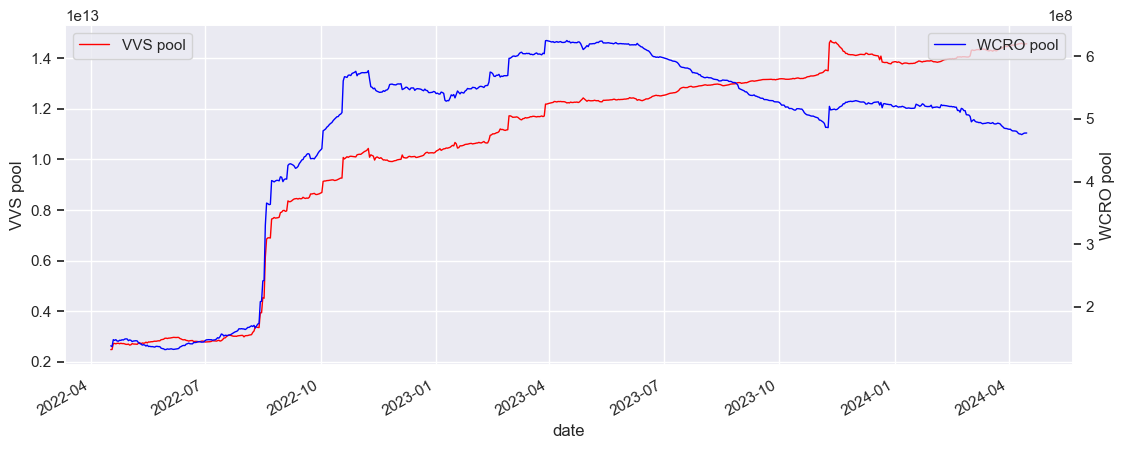

In [8]:
ax1 = df["reserve0"].plot(figsize=(13,5), linewidth=1, color="red", label=f"{token0} pool")
ax1.set_ylabel(f"{token0} pool")
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.set_ylabel(f"{token1} pool")
df["reserve1"].plot(ax=ax2, linewidth=1, color="blue", label=f"{token1} pool")
plt.legend(loc="upper right")
plt.grid()
plt.show()

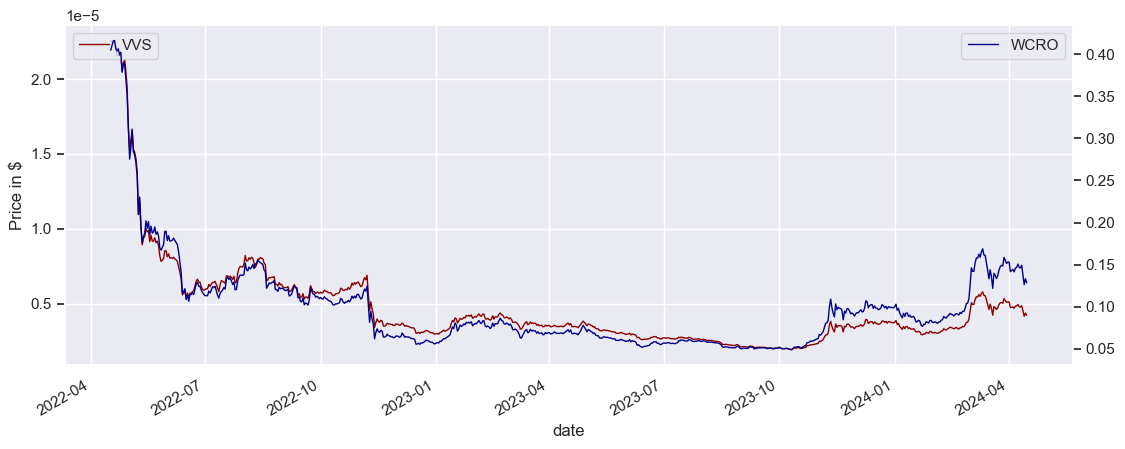

In [9]:
ax1 = df["priceToken0inDollars"].plot(figsize=(13,5), linewidth=1, color="darkred", label=f"{token0}")
ax1.set_ylabel(f"Price in $")
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
df["priceToken1inDollars"].plot(ax=ax2, linewidth=1, color="darkblue", label=f"{token1}")
plt.legend(loc="upper right")
plt.grid()
plt.show()

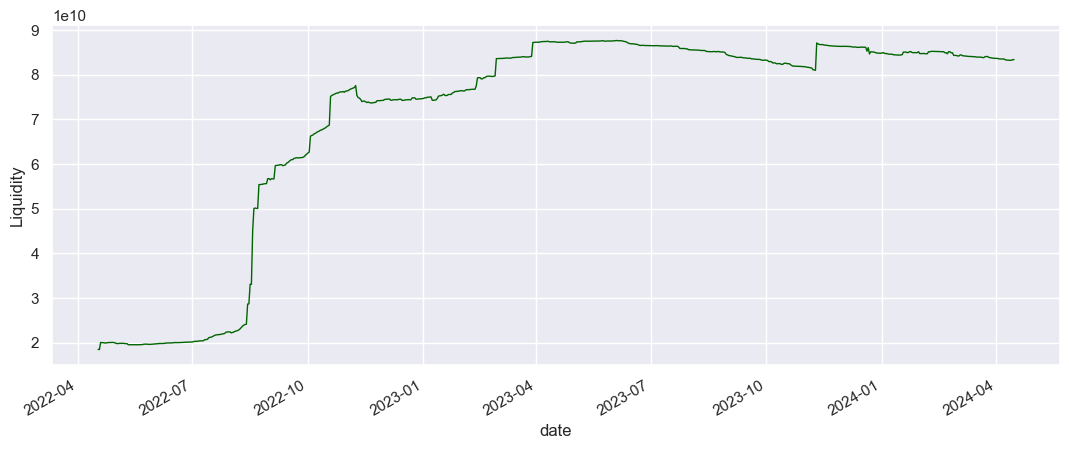

In [10]:
df["liquidity"].plot(figsize=(13,5), linewidth=1, color="darkgreen")
plt.ylabel("Liquidity")
plt.show()

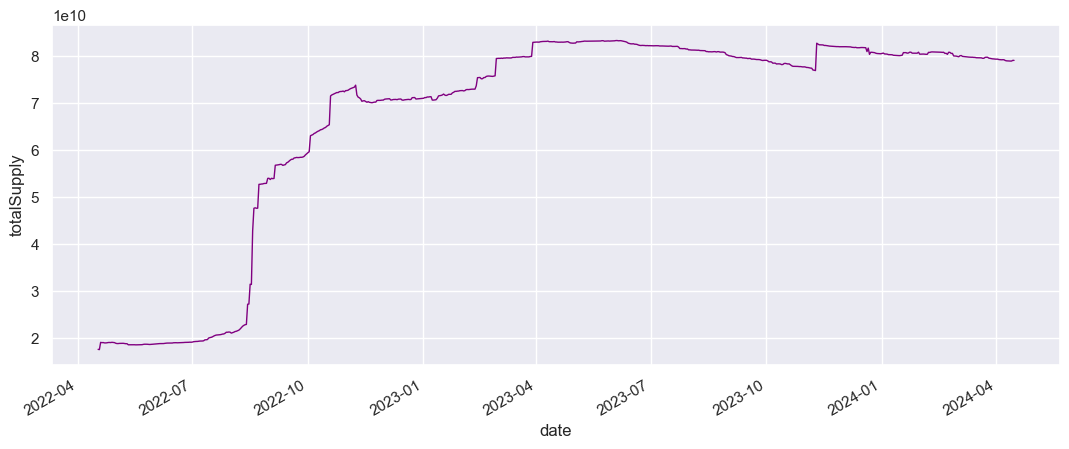

In [11]:
df["totalSupply"].plot(figsize=(13,5), linewidth=1, color="purple")
plt.ylabel("totalSupply")
plt.show()

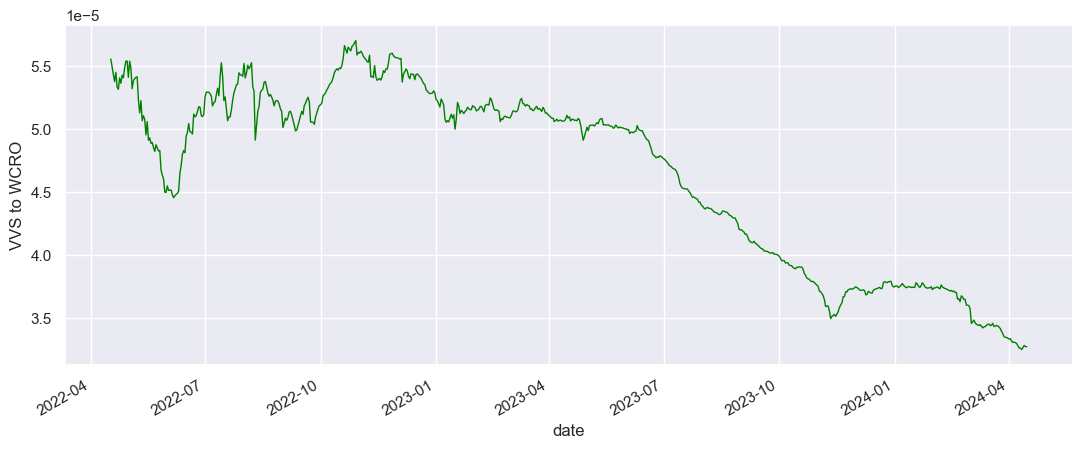

In [12]:
df["price"].plot(figsize=(13,5), linewidth=1, color="green")
plt.ylabel(f"{token0} to {token1}")
plt.show()

In [447]:
df["totalVolume"] = df["dailyVolume0"]*df["priceToken0inDollars"]

start = 365
delay = 3*30

N = len(df)

X = 365/delay

amount = 100

lp_apy = np.zeros(N-start)
lp_versus_hold_apy = np.zeros(N-start)
fees_apy = np.zeros(N-start)
il_apy = np.zeros(N-start)
hold_apy = np.zeros(N-start)

for i in range(start, N):
    qToken0_current = df["reserve0"][i-delay:i]/df["totalSupply"][i-delay:i]
    qToken1_current = df["reserve1"][i-delay:i]/df["totalSupply"][i-delay:i]
    
    plp_current = qToken0_current*df["priceToken0inDollars"][i-delay:i]
    plp_current = plp_current + qToken1_current*df["priceToken1inDollars"][i-delay:i]
    qty_current = amount/plp_current[0]
    plp_current = qty_current*plp_current

    volume_current = df["dailyVolume0"][i-delay:i]*df["priceToken0inDollars"][i-delay:i]

    fees_current = qty_current*df["totalVolume"][i-delay:i][1:].to_numpy()*fees*adj_fees/100/df["totalSupply"][i-delay:i][:-1].to_numpy()
    fees_current = np.concatenate((np.array([0.0]), fees_current))

    hold_current = qToken0_current[0]*df["priceToken0inDollars"][i-delay:i]
    hold_current = hold_current + qToken1_current[0]*df["priceToken1inDollars"][i-delay:i]
    hold_current = qty_current*hold_current

    perf_hodl_current = (hold_current[-1]-hold_current[0])/hold_current[0]
    perf_fees_current = np.sum(fees_current)/hold_current[0]
    perf_il_current = np.minimum((plp_current[-1]-np.sum(fees_current)-hold_current[-1])/hold_current[0], 0)
    
    current_lp_apy = ((1 + perf_hodl_current + perf_fees_current + perf_il_current)**X-1)
    current_lp_versus_hold_apy = ((1 + perf_fees_current + perf_il_current)**X-1)
    current_fees_apy = ((1 + perf_fees_current)**X-1)
    current_il_apy = ((1 + perf_il_current)**X-1)
    current_hold_apy = ((1 + perf_hodl_current)**X-1)

    lp_apy[i-start] = current_lp_apy
    lp_versus_hold_apy[i-start] = current_lp_versus_hold_apy
    fees_apy[i-start] = current_fees_apy
    il_apy[i-start] = current_il_apy
    hold_apy[i-start] = current_hold_apy

id_pool = 6

for i in range(N-start):
    cur.execute("""
        UPDATE public.analytics SET
    
            lp_apy_3m = %(lp_apy)s,
            lp_vs_hold_apy_3m = %(lp_vs_hold_apy)s,
            fee_apy_3m = %(fee_apy)s,
            il_apy_3m = %(il_apy)s,
            hold_apy_3m = %(hold_apy)s

        WHERE id_pool = %(id_pool)s AND date = %(date)s""",

        {'lp_apy': lp_apy[i],
         'lp_vs_hold_apy': lp_versus_hold_apy[i],
         'fee_apy': fees_apy[i],
         'il_apy': il_apy[i],
         'hold_apy': hold_apy[i],
         'id_pool': id_pool,
         'date': df.index[start+i].floor(freq="d")})

for i in range(N-start):
    cur.execute("""
        UPDATE public.analytics SET
    
            lp_apy_1m = %(lp_apy)s,
            lp_vs_hold_apy_1m = %(lp_vs_hold_apy)s,
            fee_apy_1m = %(fee_apy)s,
            il_apy_1m = %(il_apy)s,
            hold_apy_1m = %(hold_apy)s

        WHERE id_pool = %(id_pool)s AND date = %(date)s""",

        {'lp_apy': lp_apy[i],
         'lp_vs_hold_apy': lp_versus_hold_apy[i],
         'fee_apy': fees_apy[i],
         'il_apy': il_apy[i],
         'hold_apy': hold_apy[i],
         'id_pool': id_pool,
         'date': df.index[start+i].floor(freq="d")})

for i in range(N-start):
    cur.execute("""
        UPDATE public.analytics SET
    
            lp_apy_1y = %(lp_apy)s,
            lp_vs_hold_apy_1y = %(lp_vs_hold_apy)s,
            fee_apy_1y = %(fee_apy)s,
            il_apy_1y = %(il_apy)s,
            hold_apy_1y = %(hold_apy)s

        WHERE id_pool = %(id_pool)s AND date = %(date)s""",

        {'lp_apy': lp_apy[i],
         'lp_vs_hold_apy': lp_versus_hold_apy[i],
         'fee_apy': fees_apy[i],
         'il_apy': il_apy[i],
         'hold_apy': hold_apy[i],
         'id_pool': id_pool,
         'date': df.index[start+i].floor(freq="d")})

In [448]:
start = 365
delay = 365

T = 1
nDays = 256
n = T*nDays

amount = 100
ThresholdsVeV = np.array([5, 10, 15, 30, 50, 80])

volatility_score = np.zeros(N-start)
mrm = np.zeros(N-start)

for i in range(start, N):
    
    price_current = df["price"][i-delay:i]
    return_current = price_current.pct_change(periods=1)[1:]
    
    log_return_current = np.log(return_current+1)[1:]
    
    current_mean = np.mean(log_return_current)
    current_sigma = np.sqrt(np.mean((log_return_current-current_mean)**2))
    current_s = np.mean((log_return_current-current_mean)**3)/current_sigma**3
    current_k = np.mean((log_return_current-current_mean)**4)/current_sigma**4-3
    
    current_VaR = current_sigma*np.sqrt(n)*(-1.96 + 0.474*current_s/np.sqrt(n) - 0.0687*current_k/n + 0.146*current_s**2/n) - 0.5*current_sigma**2*n
    current_VeV = np.sqrt(3.842-2*current_VaR)-1.96
    current_VeV = current_VeV/np.sqrt(T)

    if(current_VeV*100 < ThresholdsVeV[0]):
        categorieVeV = 1
    elif(ThresholdsVeV[0] <= current_VeV*100 < ThresholdsVeV[1]):
        categorieVeV = 2
    elif(ThresholdsVeV[1] <= current_VeV*100 < ThresholdsVeV[2]):
        categorieVeV = 3
    elif(ThresholdsVeV[2] <= current_VeV*100 < ThresholdsVeV[3]):
        categorieVeV = 4
    elif(ThresholdsVeV[3] <= current_VeV*100 < ThresholdsVeV[4]):
        categorieVeV = 5
    elif(ThresholdsVeV[4] <= current_VeV*100 < ThresholdsVeV[5]):
        categorieVeV = 6
    elif(ThresholdsVeV[5] <= current_VeV*100):
        categorieVeV = 7

    volatility_score[i-start] = current_VeV
    mrm[i-start] = categorieVeV

id_pool = 6

for i in range(N-start):
    cur.execute("""
        UPDATE public.analytics SET
    
        volatility_score = %(volatility_score)s,
        mrm = %(mrm)s
    
        WHERE id_pool = %(id_pool)s AND date = %(date)s""",
        
        {'volatility_score': volatility_score[i],
        'mrm': mrm[i],
        'id_pool': id_pool,
        'date': df.index[start+i].floor(freq="d")})